# Optimisation: Maximising a log-likelihood

As well as minimising error functions, PINTS optimisation can be used to find the maximum of a loglikelihood (or of any [pints.LogPDF object](https://pints.readthedocs.io/en/latest/log_pdfs.html#pints.LogPDF)).

Following on from the [first example](optimisation-first-example.ipynb), we can define an inference problem using the [logistic model](https://pints.readthedocs.io/en/latest/toy/logistic_model.html#module-pints.toy):

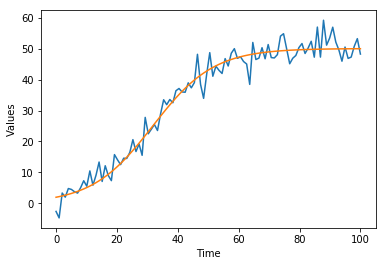

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy as toy

# Create a model
model = toy.LogisticModel()

# Set some parameters
real_parameters = [0.1, 50]

# Create fake data
times = model.suggested_times()
values = model.simulate(real_parameters, times)
noisy_values = values + np.random.normal(0, 3, times.shape)

# Create an inference problem
problem = pints.SingleOutputProblem(model, times, noisy_values)

# Show the generated data
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values)
plt.plot(times, values)
plt.show()

As before, we can define an error function and minimise it:

In [6]:
score = pints.SumOfSquaresError(problem)

boundaries = pints.RectangularBoundaries([0, 5], [1, 500])

x0 = np.array([0.5, 200])
opt = pints.OptimisationController(score, x0, method=pints.XNES)
opt.set_log_to_screen(False)
x1, f1 = opt.run()
print('Estimated parameters:')
print(x1)

Estimated parameters:
[  0.10037469  50.10312821]


We could also however define the inference problem statistically, by specifying a likelihood.

In [7]:
log_likelihood = pints.GaussianLogLikelihood(problem)

Then use an optimisation routine to find the maximum likelihood estimates. (Note that the below is supposed to fail.)

In [8]:
opt = pints.OptimisationController(log_likelihood, x0, method=pints.XNES)
x2, f2 = opt.run()

ValueError: Starting point must have same dimension as function to optimise.

Uh oh! What's happened here?

The likelihood function we used requires a `sigma` parameter, an extra parameter it adds to the inference problem that describes the estimated noise level in the data.

This means the number of parameters in our log-likelihood has gone up by one from the problem's number of parameters:

In [9]:
print(model.n_parameters())

2


In [10]:
print(problem.n_parameters())

2


In [11]:
print(log_likelihood.n_parameters())

3


As a result, we need to update our initial point (and boundaries) with a guess for what sigma may be.

In a realistic situtation, we could try to find a flat bit of signal to obtain a first estimate. In this example, we'll just start off by guessing `sigma=1`:

In [12]:
y0 = np.array([0.5, 200, 1])

boundaries_3d = pints.RectangularBoundaries([0, 5, 1e-3], [1, 500, 10])

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Estimated parameters:
[  0.10037469  50.10312827   3.20941377]


Note that the noise has introduced a slight bias into the outcome, and the estimated sigma is slightly smaller than the true value of 3.

As before, we can now plot a simulation with the obtained parameters, and see how it matches the data:

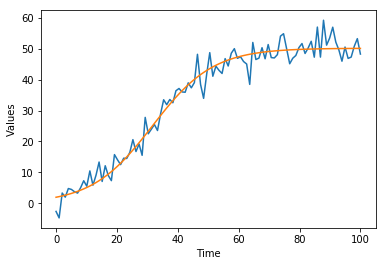

In [13]:
# Show the generated data
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy_values)
plt.plot(times, problem.evaluate(y1[:2]))
plt.show()

We can now estimate profile likelihood confidence intervals for the carrying capacity parameter by fixing the other parameters at their maximum likelihood estimates. In classical statistics, it is assumed that the log-likelihood near the maximum likelihood estimates is well approximated by a normal distribution. When this assumption breaks down, because the likelihood distribution is skewed, some prefer to use profile likelihood approaches to construct confidence intervals (others - us included - prefer Bayesian approaches which don't rely on such assumptions).

To start, let's plot the profile log-likelihood.

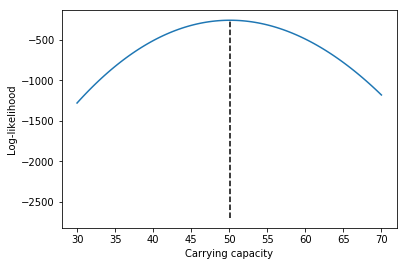

In [40]:
kappa = np.linspace(30, 70, 100)
log_prob = [log_likelihood([y1[0], k, y1[2]]) for k in kappa]
plt.plot(kappa, log_prob)
plt.vlines(y1[1], ymin=-2700, ymax=log_likelihood(y1), linestyles='dashed')
plt.xlabel('Carrying capacity')
plt.ylabel('Log-likelihood')
plt.show()

To construct a profile likelihood $(1-\alpha)$% confidence interval we determine the region in parameter space that satisfies:

$$\text{log } p(X|\theta, \hat{\phi}) \geq \text{log } p(X|\hat{\theta}, \hat{\phi}) - \frac{1}{2}\chi(1)^2_{1-\alpha},$$

where $\theta$ is the parameter we are seeking a confidence interval for and $\phi$ is a vector of other parameters; the $(\hat{\theta},\hat{\phi})$ variables indicate the maximum likelihood estimates; and $\chi(1)^2_{1-\alpha}$ represents the $\alpha$% critical values of a chi-squared distribution with one degree of freedom.

First we obtain the threshold value of log-likelihood to construct a 95% confidence interval.

In [44]:
import scipy.stats
chi2 = scipy.stats.chi2.ppf(0.95, df=1)
log_likelihood_min = log_likelihood(y1) - chi2 / 2
print(log_likelihood_min)

-260.423411674


Next we find the bounds of this region, which yields the 95% confidence interval on this parameter.

In [52]:
import scipy.optimize
def log_likelihood_bounds(k):
    return (log_likelihood([y1[0], k, y1[2]]) - log_likelihood_min)**2
res = scipy.optimize.minimize(log_likelihood_bounds, 40)
kappa_min = res.x[0]
res = scipy.optimize.minimize(log_likelihood_bounds, 60)
kappa_max = res.x[0]

print('Confidence interval = ' + str([kappa_min, kappa_max]))

Confidence interval = [49.21261601246372, 50.99522988839184]
